In [122]:
import pandas as pd

df = pd.read_csv('data/text_emotion.csv')

In [123]:
df.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [124]:
df['sentiment'].unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [125]:
len(df['sentiment'].unique())  #Number of different emotions

13

In [126]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

text = df['content']
labels = df['sentiment']

tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)

text = tokenizer.texts_to_sequences(text)

#Setting the sequence length for the padding
seq_length = 30

sequences = pad_sequences(text, maxlen = seq_length)

In [170]:
text

[[15231, 1, 55, 1, 25, 3309, 2, 120, 4672, 856, 6, 1, 614, 1405, 24, 184, 560],
 [9778, 279, 147, 22, 4, 434, 3559, 2621, 14, 42, 292],
 [2766, 4220, 1766, 236],
 [445, 2, 719, 31, 22, 215, 175],
 [15232, 62, 83, 2, 3310, 22, 262, 186, 101, 2622, 651, 18, 35, 52, 60],
 [747, 6166, 15233, 113, 151, 7, 39, 2, 883, 1378, 5, 1521, 151, 34, 5, 215],
 [1,
  137,
  23,
  134,
  18,
  59,
  26,
  374,
  64,
  91,
  233,
  248,
  186,
  1,
  83,
  18,
  346,
  1606,
  30,
  243,
  68,
  114,
  445,
  13,
  80,
  7508],
 [943, 38, 385, 15234, 58, 9, 179],
 [15235, 15236, 5, 44, 1, 94, 7],
 [15237, 20, 118, 24, 350, 40, 236],
 [189, 803, 636],
 [7509, 14, 100, 9779],
 [286, 1, 15, 2, 1124, 29, 383, 298, 2, 33, 2, 3, 150, 2008],
 [9780,
  74,
  54,
  218,
  3,
  2263,
  10,
  769,
  54,
  60,
  2915,
  57,
  15238,
  8,
  9,
  206,
  155,
  453,
  6,
  453,
  331,
  1,
  19,
  218,
  15239],
 [46, 3, 502],
 [3, 1437, 9, 92, 6, 3, 4673, 9, 316],
 [15240, 2623],
 [16, 977, 109, 6, 40, 26, 166, 17, 3

The average length of the sequences before padding is: 13.5158 words
The max length of the sequences before padding is: 37 words
The min length of the sequences before padding is: 1 words


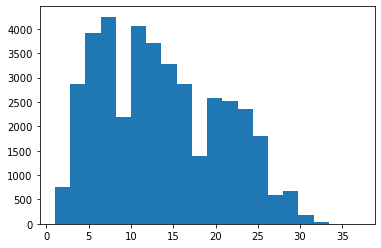

In [127]:
import numpy as np
import matplotlib.pyplot as plt

agg_list = np.array([len(i) for i in text])
avg_length = agg_list.mean()
max_length = np.array([len(i) for i in text]).max()
min_length = np.array([len(i) for i in text]).min()

print("The average length of the sequences before padding is: {} words".format(avg_length))
print("The max length of the sequences before padding is: {} words".format(max_length))
print("The min length of the sequences before padding is: {} words".format(min_length))

plt.hist(agg_list, bins = 20)
plt.show()

In [128]:
emotion_dict = {}

for k in range(len(labels.unique())):
    emotion_dict[labels.unique()[k]] = k
    
print('Creating the emotion dict to encode the label')

Creating the emotion dict to encode the label


In [129]:
#Creating the encoded target

encoded_labels = np.array(list(labels.map(lambda x: emotion_dict[x])))

In [130]:
split_frac = 0.8

## split data into training, validation, and test data (features and labels, x and y)

split_idx = int(len(sequences)*split_frac)
train_x, val_x = sequences[:split_idx], sequences[split_idx:]
train_y, val_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape))

			Feature Shapes:
Train set: 		(32000, 30) 
Validation set: 	(8000, 30)


In [131]:
import os 

embeddings_index = {}
f = open(os.path.join("data/embedding/", 'glove.6B.50d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


In [132]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 50))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [133]:
# First checking if GPU is available

import torch

train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

No GPU available, training on CPU.


In [163]:
import torch.nn as nn


class Net(nn.Module):
    
    def __init__(self, num_layers, hidden_dim, 
                 embedding_dim, embedding_dict_size, 
                 seq_length, output_size):
        super(Net,self).__init__()
        
        self.n_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.embedding_dict_size = embedding_dict_size
        self.seq_length = seq_length
        self.output_size = output_size
        
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix))
    
        #self.embedding = nn.Embedding(self.embedding_dict_size, self.embedding_dim)
        
        self.lstm = nn.LSTM(input_size=self.seq_length, hidden_size=self.hidden_dim, 
                            num_layers=self.n_layers, batch_first = True)
        
        self.dropout = nn.Dropout()
        
        self.fc = nn.Linear(self.hidden_dim, output_size)
        self.softmax = nn.Softmax(dim=1)

        
    def forward(self, x, hidden):
        
        embeds = self.embedding(x)
        embeds = embeds.view(batch_size,self.embedding_dim,self.seq_length).type(torch.float)
        lstm_out, hidden = self.lstm(embeds)
        lstm_out = lstm_out.contiguous().view(batch_size, self.embedding_dim, self.hidden_dim)
        out = self.softmax(self.fc(lstm_out))
        out = out[:,-1,:]

        
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

In [164]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
val_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))

# dataloaders
batch_size = 64

# make sure the SHUFFLE your training data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)

In [165]:
len(emotion_dict)

13

In [166]:
#Parameter settting

from torch import optim

num_layers = 1
hidden_dim = 50
output_size = len(df['sentiment'].unique())
embedding_dim = 50
vocab_size = len(tokenizer.word_index) + 1
output_size = len(emotion_dict)

learning_rate = 0.001

net = Net(num_layers, hidden_dim, embedding_dim, vocab_size, seq_length, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = learning_rate)

In [167]:
print(net)

Net(
  (embedding): Embedding(48998, 50)
  (lstm): LSTM(30, 50, batch_first=True)
  (dropout): Dropout(p=0.5)
  (fc): Linear(in_features=50, out_features=13, bias=True)
  (softmax): Softmax()
)


In [169]:
from sklearn.metrics import f1_score, recall_score, accuracy_score

nb_epochs = 4
counter = 0
clip = 5
print_every = 64

if(train_on_gpu):
    net.cuda()

for epoch in range(nb_epochs):
    
    h = net.init_hidden(batch_size)
    net.train()
    
    for text_sequences, targets in train_loader:
        
        counter += 1
        
        #resetting the gradient
        net.zero_grad()
        
        if(train_on_gpu):
            text_sequences, targets = text_sequences.cuda(), targets.cuda()
            
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
            
        #Not sure why pytorch refuses the indices of text_sequences to be int.32
        input_text = text_sequences.type(torch.long)
        outputs, h = net(input_text, h) 
        loss = criterion(outputs, targets)
        loss.backward()
        
        #Clipping gradient to avoid exploding gradients
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        
        optimizer.step()
        
        
    # Get validation loss
    val_h = net.init_hidden(batch_size)
    val_losses = []
    y_pred_list = []
    y_true_list = []
    net.eval()
            
    for text_sequences, targets in val_loader:
        # Get validation loss

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        val_h = tuple([each.data for each in val_h])

        if(train_on_gpu):
            text_sequences, targets = text_sequences.cuda(), targets.cuda()
                
        input_text = text_sequences.type(torch.long)
        outputs, val_h = net(input_text, val_h)
        val_loss = criterion(outputs, targets)
        val_losses.append(val_loss.item())
                
        y_pred = outputs.cpu().detach().numpy().argmax(axis=1)
        y_pred_list += y_pred.tolist()
        y_true_list += targets.cpu().detach().numpy().tolist()
            
    net.train()
    print("Epoch: {}/{}...".format(epoch+1, nb_epochs),
            "Step: {}...".format(counter),
            "Loss: {:.6f}...".format(loss.item()),
            "Val Loss: {:.6f}".format(np.mean(val_losses)),
            "Val f1: {:.6f}  ".format(f1_score(y_true_list, y_pred_list, average='weighted')),
            "Val recall: {:.6f}".format(recall_score(y_true_list,y_pred_list, average='weighted')))

Epoch: 1/4... Step: 500... Loss: 2.564943... Val Loss: 2.564888 Val f1: 0.090729   Val recall: 0.098500
Epoch: 2/4... Step: 1000... Loss: 2.564996... Val Loss: 2.564886 Val f1: 0.090212   Val recall: 0.098250
Epoch: 3/4... Step: 1500... Loss: 2.564784... Val Loss: 2.564885 Val f1: 0.090144   Val recall: 0.098375
Epoch: 4/4... Step: 2000... Loss: 2.565018... Val Loss: 2.564883 Val f1: 0.090501   Val recall: 0.098750


In [162]:
outputs

tensor([[0.0204, 0.0197, 0.0227, 0.0202, 0.0188, 0.0195, 0.0207, 0.0221, 0.0200,
         0.0207, 0.0208, 0.0188, 0.0192],
        [0.0193, 0.0195, 0.0202, 0.0198, 0.0215, 0.0202, 0.0193, 0.0192, 0.0197,
         0.0186, 0.0193, 0.0210, 0.0205],
        [0.0203, 0.0192, 0.0226, 0.0189, 0.0185, 0.0200, 0.0205, 0.0209, 0.0196,
         0.0214, 0.0201, 0.0198, 0.0188],
        [0.0198, 0.0199, 0.0224, 0.0201, 0.0193, 0.0202, 0.0203, 0.0210, 0.0200,
         0.0205, 0.0210, 0.0203, 0.0185],
        [0.0210, 0.0200, 0.0231, 0.0199, 0.0188, 0.0191, 0.0216, 0.0210, 0.0199,
         0.0208, 0.0204, 0.0205, 0.0186],
        [0.0210, 0.0200, 0.0231, 0.0199, 0.0211, 0.0194, 0.0225, 0.0219, 0.0203,
         0.0199, 0.0206, 0.0205, 0.0189],
        [0.0212, 0.0193, 0.0226, 0.0199, 0.0193, 0.0208, 0.0214, 0.0220, 0.0203,
         0.0196, 0.0210, 0.0195, 0.0197],
        [0.0196, 0.0190, 0.0201, 0.0204, 0.0215, 0.0209, 0.0205, 0.0195, 0.0198,
         0.0203, 0.0221, 0.0200, 0.0182],
        [0.0205,

In [16]:
model = torch.load('data/lstm_model.pt',map_location='cpu')

In [17]:
print(model)

Net(
  (embedding): Embedding(48998, 200)
  (lstm): LSTM(30, 50, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.5)
  (fc): Linear(in_features=50, out_features=13, bias=True)
)


In [18]:
model.eval()

Net(
  (embedding): Embedding(48998, 200)
  (lstm): LSTM(30, 50, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.5)
  (fc): Linear(in_features=50, out_features=13, bias=True)
)